This notebooks shows how **Electrical Resistivity Tomography** (ERT) works through `pyGIMLi`.  The example is directly taken from <https://github.com/halbmy/GeophysicalMethods/blob/main/notebooks/04howERTworks.ipynb>

**Author:** Alberto Carrera

In [1]:
import numpy as np
import pygimli as pg
import pygimli.physics.ert as ert
import pygimli.meshtools as mt
from pygimli.viewer.mpl import drawStreams

import ERTutils as utils

# Introduction
Electrical Resistivity Tomography (ERT) is a geophysical method used to image the subsurface electrical resistivity distribution.  It relies on the fact that different geological materials exhibit different electrical properties.  
The method is based on **Ohm’s law**:

$$
\vec{J} = \sigma \vec{E}
$$

where:
- $\vec{J}$ is the current density (A/m²)  
- $\sigma$ is the electrical conductivity (S/m), with $\rho = 1 / \sigma$ being resistivity (Ω·m) 
- $\vec{E}$ is the electric field (V/m)

The electric field is related to the scalar potential $u$:

$$
\vec{E} = -\nabla u
$$

By injecting current through a pair of electrodes (A, B) and measuring the potential difference at another pair (M, N) we can estimate the apparent resistivity $\rho_a$ of the subsurface.  
Find out more details [here](https://www.eoas.ubc.ca/courses/eosc350/content/methods/meth_1/measurements.htm#Current) and [here](https://em.geosci.xyz/content/geophysical_surveys/dcr/index.html).


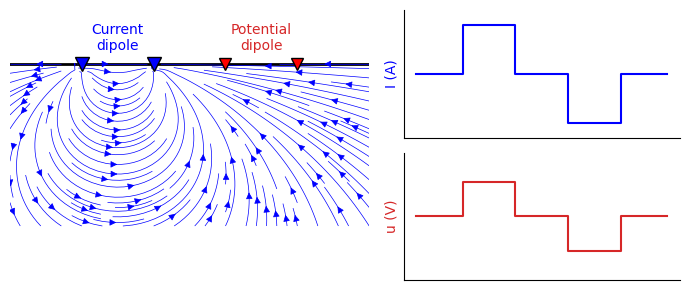

In [2]:
utils.plotDCscheme()

## Synthetic homogeneous model: potential distribution and electric field

We begin by defining a synthetic survey setup and constructing a simple resistivity model. Electrodes are placed on the surface, and a finite-element mesh is generated. 

02/09/25 - 10:04:05 - pyGIMLi - INFO - Cache /home/alberto/anaconda3/envs/electro/lib/python3.11/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 49): /home/alberto/.cache/pygimli/6164026747729610847


Mesh: Nodes: 883 Cells: 1657 Boundaries: 2539


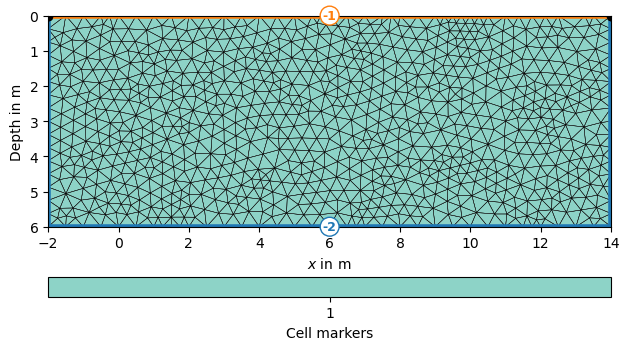

In [3]:
# create data scheme
shm = ert.createData(elecs=12, schemeName="dd") # dd=dipole-dipole
shm["k"] = ert.createGeometricFactors(shm) # compute K

# create world
world = mt.createWorld(start=[-2, 0], end=[14, -6], worldMarker=True, marker=1)
for pos in shm.sensorPositions():
    world.createNode(pos)
    
# create mesh
mesh = mt.createMesh(world, area=.1, quality=33, smooth=[1, 10])
pg.show(mesh, markers=True, showMesh=True)
print(mesh)

This allows us to compute the electric field distribution once the potential field is simulated in the mesh.  
The electric field is the spatial derivative of the potential ($\vec{E} = -\nabla u$).  
The governing relation for the electric potential due to a point current source in a homogeneous half-space is:

$$
u(r) = \frac{I}{2\pi\sigma r} = \frac{\rho I}{2\pi r}
$$

where:
- $I$ = injected current (A)  
- $r$ = distance from the current source (m)  

From this, the apparent resistivity can be expressed as:

$$
\rho_a = k \cdot R
$$

with:
- $R = \frac{\Delta U}{I}$ the measured resistance (Ω)  
- $k$ the geometric factordepending on electrode configuration (e.g., dipole–dipole, Wenner, Schlumberger).  

This formula transforms a geometry-dependent resistance into a geometry-independent apparent resistivity $\rho_a$.

## Single potential field – solution for one current source
The potential field created by a single source electrode (fundamental solution):

ModellingBase::setMesh() copying new mesh ... Found datafile: 12 electrodes
Found: 12 free-electrodes
rMin = 0.5, rMax = 22
NGauLeg + NGauLag for inverse Fouriertransformation: 9 + 4
Found non-Neumann domain
0.0120955 s
FOP updating mesh dependencies ... 2.398e-06 s
Calculating response for model: min = 100 max = 100
Allocating memory for primary potential...... 0.000665296

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 0.101124s
Response: min = 99.7031 max = 100.13 mean = 99.929
Reciprocity rms(modelReciprocity) 0%, max: 0%


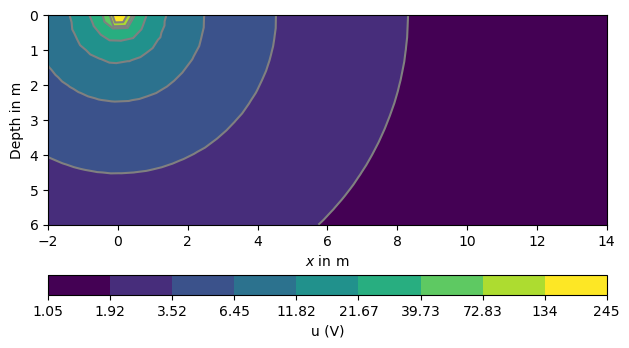

In [4]:
# make a simulation
pot = ert.simulate(mesh=mesh, scheme=shm, res=[[1, 100]], returnFields=1)

ax, cb = pg.show(mesh, pot[0], logScale=True, nLevs=10, label="u (V)")

## Electric field – spatial gradient of the potential
Now we see how the potential changes with depth. The electric field is the driver of current density.  
Here we show the vertical component of $\vec{E}$

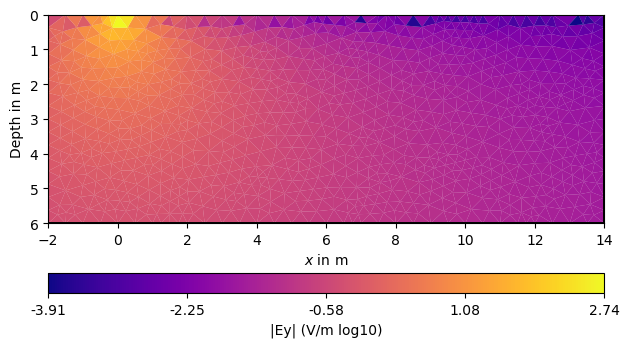

In [5]:
E = -pg.solver.grad(mesh, pot[0]) # compute electric field E

ax, cb = pg.show(mesh, np.log10(np.abs(E[:, 1])), cMap='plasma', 
                 label="|Ey| (V/m log10)")

## Four-electrode potential distribution – combined effect of current injection between two electrodes
The path of the current in the earth after it is injected with two electrodes depends upon the distribution of electrical resistivity. If the Earth is uniform, current flows in a regular three dimensional pattern under the electrodes.  
The true field for a dipole source (A–B current injection) is:

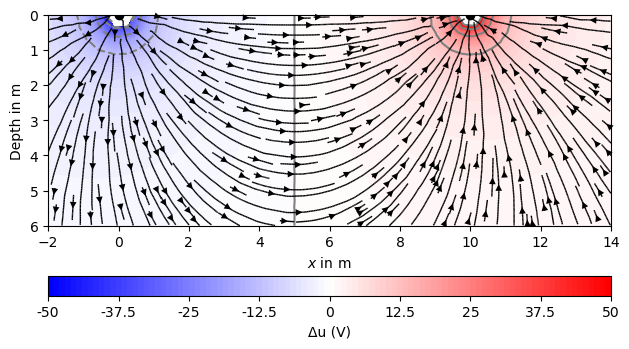

In [6]:
u = pot[10] - pot[0]   # A–B current pair

cmax = 50
ax, cb = pg.show(mesh, u, cMap="bwr", cMin=-cmax, cMax=cmax, nCols=100,
                 nLevs=9, label="Δu (V)")
ax.plot([0, 10], [0, 0], "ko")
drawStreams(ax, mesh, u, color="Black")

## Two-Layer Model
We extend the example to a two-layer case, where resistivity changes with depth. This setup illustrates how subsurface resistivity contrasts influence the potential field.  

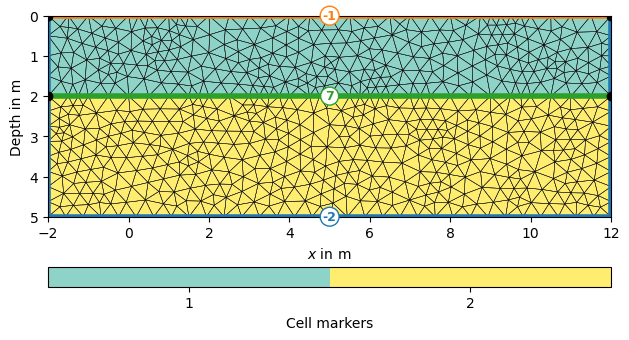

In [6]:
# create world
layers = mt.createWorld(start=[-2, 0], end=[12, -5], layers=[-2], worldMarker=True)
for pos in shm.sensorPositions():
    layers.createNode(pos)

# create mesh
mesh = mt.createMesh(layers, area=.1, quality=33, smooth=[1, 10])
pg.show(mesh, markers=True, showMesh=True);

ModellingBase::setMesh() copying new mesh ... Found datafile: 12 electrodes
Found: 12 free-electrodes
rMin = 0.5, rMax = 22
NGauLeg + NGauLag for inverse Fouriertransformation: 9 + 4
Found non-Neumann domain
0.00622419 s
FOP updating mesh dependencies ... 1.908e-06 s
Calculating response for model: min = 100 max = 1000
Allocating memory for primary potential...... 7.4872e-05

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 0.0765603s
Response: min = 97.3956 max = 264.952 mean = 136.607
Reciprocity rms(modelReciprocity) 0.426014%, max: 0.987598%


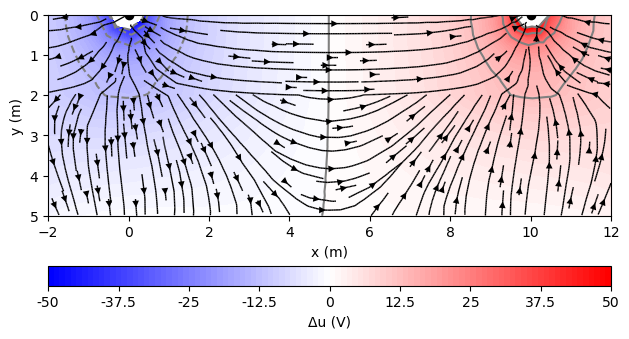

In [7]:
# simulate
pot = ert.simulate(mesh=mesh, scheme=shm, res=[[1, 100], [2, 1000]], returnFields=1) # 10

# plot
u = pot[10] - pot[0] # A–B current pair
cmax = 50
ax, cb = pg.show(mesh, u, cMap="bwr", cMin=-cmax, cMax=cmax, nCols=100,
                 nLevs=9, label="Δu (V)")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.plot([0, 10], [0, 0], "ko");
drawStreams(ax, mesh, u, color='Black');

## Inhomogeneous Model
We now introduce some localized resistivity anomalies (i.e., conductive clay lenses, resistive boulders) embedded in a background half-space

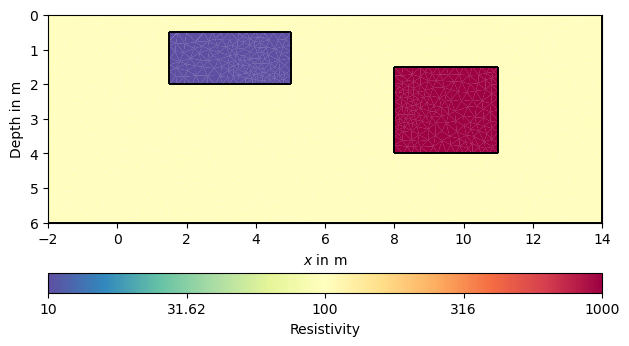

In [8]:
# create anomalies
rect = mt.createRectangle(start=[1.5, -2], end=[5, -0.5], marker=2)
rect2 = mt.createRectangle(start=[8, -4], end=[11, -1.5], marker=3)
inhom = world + rect + rect2

# create mesh
mesh2 = mt.createMesh(inhom, area=.05, quality=34, marker=1)
resmap = [[1, 100], [2, 10], [3, 1000]]
ax, _ = pg.show(mesh2, resmap,
                label="Resistivity", logScale=True, cMap="Spectral_r")

ModellingBase::setMesh() copying new mesh ... Found datafile: 12 electrodes
Found: 12 free-electrodes
rMin = 0.5, rMax = 22
NGauLeg + NGauLag for inverse Fouriertransformation: 9 + 4
Found non-Neumann domain
0.0341973 s
FOP updating mesh dependencies ... 2.506e-06 s
Calculating response for model: min = 10 max = 1000
Allocating memory for primary potential...... 0.00184773

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 0.181193s
Response: min = 16.194 max = 163.319 mean = 65.8923
Reciprocity rms(modelReciprocity) 4.3995%, max: 13.7072%


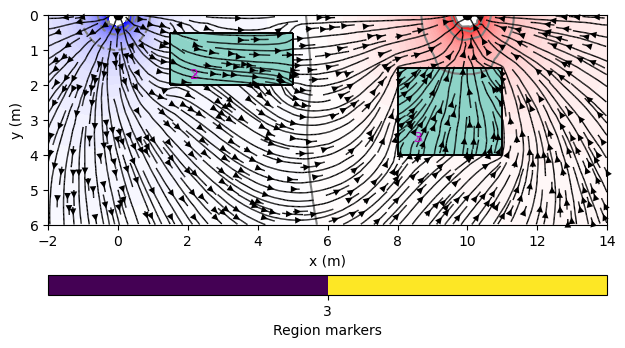

In [9]:
# simulate 
pot2 = ert.simulate(mesh=mesh2, scheme=shm, res=resmap,
                    returnFields=1)

# plot
u2 = pot2[10] - pot2[0]
ax, cb = pg.show(mesh2, u2, cMap="bwr", cMin=-cmax, cMax=cmax, nCols=100,
                 nLevs=9, label="potential (V)")
pg.show(rect, ax=ax, colorBar=False)
pg.show(rect2, ax=ax, colorBar=False)
# %%
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.plot([0, 10], [0, 0], "ko")
drawStreams(ax, mesh2, u2, color='Black')

Let's examine the apparent resistivities that we might have obtained from a field acquisition with these parameters

ModellingBase::setMesh() copying new mesh ... Found datafile: 12 electrodes
Found: 12 free-electrodes
rMin = 0.5, rMax = 22
NGauLeg + NGauLag for inverse Fouriertransformation: 9 + 4
Found non-Neumann domain
0.0250098 s
FOP updating mesh dependencies ... 1.748e-06 s
Calculating response for model: min = 10 max = 1000
Allocating memory for primary potential...... 8.5296e-05

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 0.171123s
Response: min = 16.194 max = 163.319 mean = 65.8923
Reciprocity rms(modelReciprocity) 4.3995%, max: 13.7072%


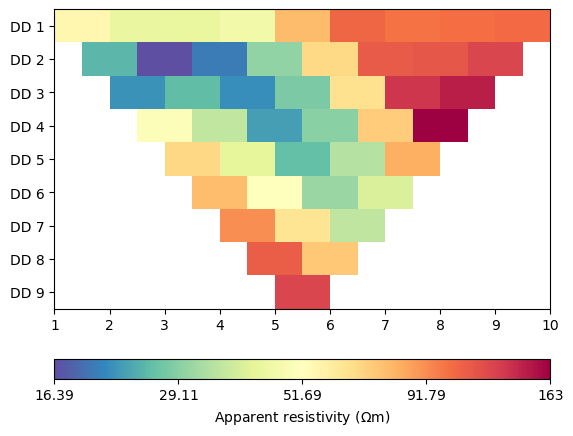

In [10]:
# simulate data
data = ert.simulate(mesh=mesh2, scheme=shm, res=resmap)

# plot
ax, _ = pg.show(data)

## Sensitivity Analysis
ERT measurements have variable sensitivity to subsurface resistivity changes: some parts of the model affect the measurements more than others. Understanding sensitivity is crucial for designing surveys and interpreting inversion results.  

The **Jacobian matrix** $J$ (also called the sensitivity matrix) quantifies how each measurement depends on each model parameter:
$$
J_{ij} = \frac{\partial d_i}{\partial m_j}
$$

where:  
- $d_i$ = data point $i$ (voltage/resistivity measurement)  
- $m_j$ = model parameter $j$ (cell resistivity)

A large $|J_{ij}|$ means that measurement $i$ is highly sensitive to changes in cell $j$. 
A small $|J_{ij}|$ means the measurement barely depends on that part of the model.  


Now we can take advantage of two functions that show us the sensitivity distribution in our discretized domain. Given an electrode array, we see how sensitive is each measurement to changes in resistivity in each cell if the medium were uniform (1 Ω·m)
1. `show4pointSens` → shows where one specific measurement is sensitive.  
2. `showSensitivity` → sum of all sensitivities, showing which regions of the model space contribute most to the dataset.


01/09/25 - 17:18:28 - pyGIMLi - INFO - Found 1 regions.
01/09/25 - 17:18:28 - pyGIMLi - INFO - Creating forward mesh from region infos.
01/09/25 - 17:18:28 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
01/09/25 - 17:18:28 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2678 Cells: 5172 Boundaries: 3970


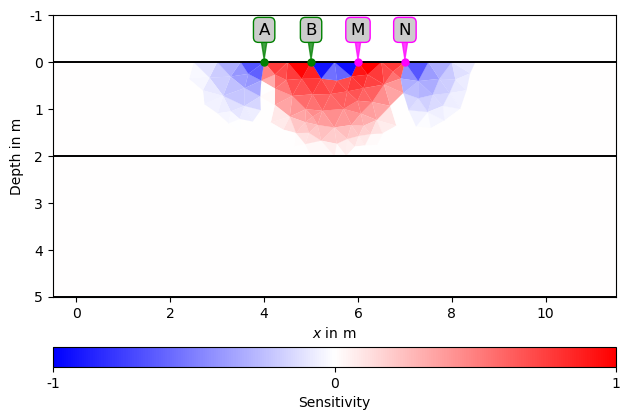

In [11]:
pos=4
utils.show4pointSens(shm, mesh, i=pos)

01/09/25 - 17:18:29 - pyGIMLi - INFO - Found 1 regions.
01/09/25 - 17:18:29 - pyGIMLi - INFO - Creating forward mesh from region infos.
01/09/25 - 17:18:29 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
01/09/25 - 17:18:29 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 2678 Cells: 5172 Boundaries: 3970
/home/alberto/anaconda3/envs/electro/lib/python3.11/site-packages/pygimli/viewer/mpl/meshview.py:1373: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  eSensors.append(mpl.patches.Circle((x,y), diam/2,


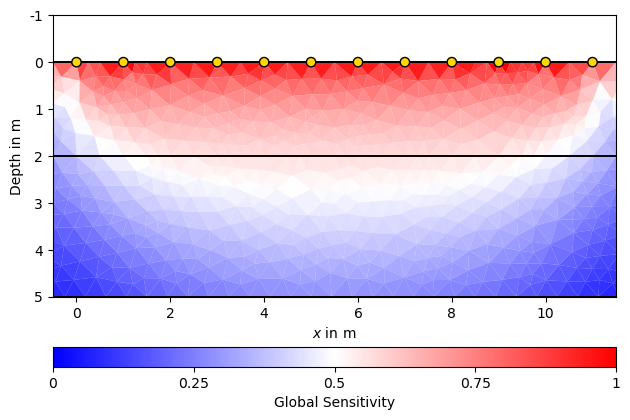

In [12]:
utils.showSensitivity(shm, mesh)

## Inversion
Finally, we invert the synthetic data to recover a resistivity model. The objective function for an **L2–Tikhonov regularized inverse problem** is:
$$
\Phi(m) = \| W_d (d_\text{obs} - f(m)) \|^2 + \lambda^2 \| W_m (m - m_0) \|^2
$$

where:  
- $d_\text{obs}$ = observed data  
- $f(m)$ = forward response of model \(m\)  
- $W_d$ = data weighting (errors)  
- $W_m$ = model weighting (regularization)  
- $\lambda$ = regularization parameter  
- $m_0$ = reference model  

The result is a smoothed resistivity distribution that best explains the measurements, constrained by regularization.  
For more info, check [here](https://geosci-inversion.curve.space/inversion-module).


In [ ]:
# initialize manager and invert
data["err"] = pg.Vector(data.size(), 0.01) # add small error
mgr = ert.Manager(data, mesh=mesh)
mgr.invert(verbose=True)

01/09/25 - 17:18:34 - pyGIMLi - INFO - Inversion stopped with chi² = 0.92


(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>,
 <matplotlib.colorbar.Colorbar at 0x748b08292590>)

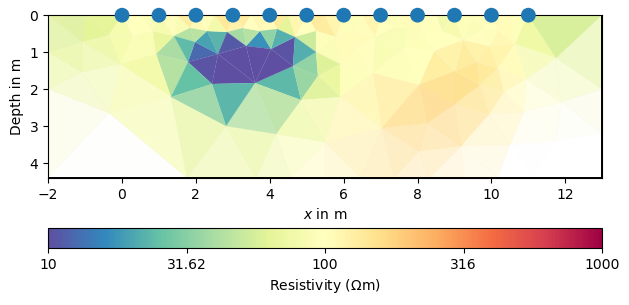

In [14]:
# show results
pg.info('Inversion stopped with chi² = {0:.2}'.format(mgr.fw.chi2()))
mgr.showResult(cMin=10, cMax=1000)

## To-Do

- [ ] Compute the Jacobian around a heterogeneous model to see how anomalies affect sensitivity.